### Notebook for plotting the figures for GFM modelled flooding

In [107]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pandas as pd
import rasterio
import geopandas as gpd
import pycountry
import numpy as np
import yaml
import os
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
import matplotlib as mpl
from adjustText import adjust_text

#### Define Functions

In [108]:
# Define function combining country inequality metric geopackages
def combine_national_inequality_metrics(country_list, model, metric, vuln_curve):
    '''
    Function for combining national metrics into one geodataframe.
    Function takes as input:
        - the list of countries to combine (ISO3 codes)
        - the flood model used (giri, jrc, or wri)
        - the metric of interest (AAR, protected_AAR, or RP100)
        - the vulnerability curve usedd (JRC, EXP, or BERN)
    '''
    # List to store individual GeoDataFrames
    gdfs = []
    # Loop over all countries in the country list
    for country in country_list:
        try:
            metric_path = os.path.join("..", "data", "results", "social_flood", "countries", f"{country}",
                                       "inequality_metrics", f"{country}_ADM0_decomposed_metrics_{model}-flood_{metric}_V-{vuln_curve}_S-rwi.gpkg")
            # Read the GeoPackage
            gdf = gpd.read_file(metric_path)
            # Append to list
            gdfs.append(gdf)
        except Exception as e:
            print(f"Error processing {country}: {e}")

    # Combine all GeoDataFrames
    if gdfs:
        combined_gdf = pd.concat(gdfs, ignore_index=True)
        return combined_gdf
    else:
        print("No valid data found")

# Define function combining country inequality metric geopackages
def combine_sub_national_inequality_metrics(country_list, model, metric, vuln_curve, ADM_level):
    '''
    Function for combining national metrics into one geodataframe.
    Function takes as input:
        - the list of countries to combine (ISO3 codes)
        - the flood model used (giri, jrc, or wri)
        - the metric of interest (AAR, protected_AAR, or RP100)
        - the vulnerability curve usedd (JRC, EXP, or BERN)
        - the admin level of the subnational (decomposed) inequality metrics
    '''
    # List to store individual GeoDataFrames
    gdfs = []
    # Loop over all countries in the country list
    for country in country_list:
        try:
            metric_path = os.path.join("..", "data", "results", "social_flood", "countries", f"{country}",
                                       "inequality_metrics", f"{country}_{ADM_level}_admin-decomposed_metrics_{model}-flood_{metric}_V-{vuln_curve}_S-rwi.gpkg")
            # Read the GeoPackage
            gdf = gpd.read_file(metric_path)
            # Append to list
            gdfs.append(gdf)
        except Exception as e:
            print(f"Error processing {country}: {e}")

    # Combine all GeoDataFrames
    if gdfs:
        combined_gdf = pd.concat(gdfs, ignore_index=True)
        return combined_gdf
    else:
        print("No valid data found")


# Define function combining country risk metric geopackages
def combine_national_risk_metrics(country_list, model, metric, vuln_curve):
    '''
    Function for combining national metrics into one geodataframe.
    Function takes as input:
        - the list of countries to combine (ISO3 codes)
        - the flood model used (giri, jrc, or wri)
        - the metric of interest (AAR, protected_AAR, or RP100)
        - the vulnerability curve usedd (JRC, EXP, or BERN)
    '''
    # List to store individual GeoDataFrames
    gdfs = []
    # Loop over all countries in the country list
    for country in country_list:
        try:
            metric_path = os.path.join("..", "data", "results", "social_flood", "countries", f"{country}",
                                       "inequality_metrics", f"{country}_ADM0_decomposed_metrics_{model}-flood_{metric}_V-{vuln_curve}_S-rwi.gpkg")
            # Read the GeoPackage
            gdf = gpd.read_file(metric_path)
            # Append to list
            gdfs.append(gdf)
        except Exception as e:
            print(f"Error processing {country}: {e}")

    # Combine all GeoDataFrames
    if gdfs:
        combined_gdf = pd.concat(gdfs, ignore_index=True)
        return combined_gdf
    else:
        print("No valid data found")

def name_to_iso3(name):
    try:
        # lookup is case-insensitive and handles many common variants
        return pycountry.countries.lookup(name).alpha_3
    except LookupError:
        return None      # or fallback string

In [109]:
# Load countries from config file
with open(os.path.join("..", "config", "config.yaml"), "r") as file:
    config = yaml.safe_load(file)
countries = config.get("iso_codes", [])
# Add trouble columns manually
manual_codes = {
    'Bosnia & Herzegovina': 'BIH',
    'Central African Rep':    'CAF',
    "Cote d'Ivoire":          'CIV',
    'Congo, Dem Rep of the':  'COD',
    'Congo, Rep of the':      'COG',
    'Gambia, The':            'GMB',
    'Macedonia':              'MKD',
    'Swaziland':              'SWZ',
    'Turkey':                 'TUR'
}

In [110]:
# CONFIG
vuln = "JRC"
risk_metric = "protected_AAR"
subnational_ADM = "ADM1"
coverage_threshold = 90 # going to use 90% first
countries_to_drop = ['Comoros', 'Cabo Verde', 'Dominica', 'Grenada', 'St Lucia', 'Maldives', 'Mauritius', 'Sao Tome & Principe', 'St Vincent & the Grenadines']

In [111]:
# Data Preperation (combining data from multiple models)
jrc_metrics = combine_national_inequality_metrics(countries, 'jrc', risk_metric, vuln)
jrc_subnational_metrics = combine_sub_national_inequality_metrics(countries, 'jrc', risk_metric, vuln, subnational_ADM)
jrc_metrics = jrc_metrics[jrc_metrics['Population Coverage (%)'] > coverage_threshold]
jrc_metrics = jrc_metrics[~jrc_metrics['shapeName'].isin(countries_to_drop)]
jrc_metrics['ISO3'] = jrc_metrics['shapeName'].map(name_to_iso3)
jrc_metrics['ISO3'] = jrc_metrics['ISO3'].fillna(jrc_metrics['shapeName'].map(manual_codes))
valid_isos = jrc_metrics['ISO3'].dropna().unique() # get valid ISOs to filter subnational
jrc_subnational_metrics['model'] = 'JRC'
jrc_subnational_metrics = jrc_subnational_metrics[jrc_subnational_metrics['ISO3'].isin(valid_isos)]
jrc_metrics['model'] = 'JRC'
giri_metrics = combine_national_inequality_metrics(countries, 'giri', risk_metric, vuln)
giri_subnational_metrics = combine_sub_national_inequality_metrics(countries, 'giri', risk_metric, vuln, subnational_ADM)
giri_metrics = giri_metrics[~giri_metrics['shapeName'].isin(countries_to_drop)]
giri_metrics['ISO3'] = giri_metrics['shapeName'].map(name_to_iso3)
giri_metrics['ISO3'] = giri_metrics['ISO3'].fillna(giri_metrics['shapeName'].map(manual_codes))
giri_metrics['model'] = 'GIRI'
giri_subnational_metrics['model'] = 'GIRI'
giri_subnational_metrics = giri_subnational_metrics[giri_subnational_metrics['ISO3'].isin(valid_isos)]
giri_metrics = giri_metrics[giri_metrics['Population Coverage (%)'] > coverage_threshold]
wri_metrics = combine_national_inequality_metrics(countries, 'wri', risk_metric, vuln)
wri_subnational_metrics = combine_sub_national_inequality_metrics(countries, 'wri', risk_metric, vuln, subnational_ADM)
wri_metrics = wri_metrics[wri_metrics['Population Coverage (%)'] > coverage_threshold]
wri_metrics = wri_metrics[~wri_metrics['shapeName'].isin(countries_to_drop)]
wri_metrics['ISO3'] = wri_metrics['shapeName'].map(name_to_iso3)
wri_metrics['ISO3'] = wri_metrics['ISO3'].fillna(wri_metrics['shapeName'].map(manual_codes))
wri_metrics['model'] = 'WRI'
wri_subnational_metrics = wri_subnational_metrics[wri_subnational_metrics['ISO3'].isin(valid_isos)]
wri_subnational_metrics['model'] = 'WRI'
# Columns to keep
cols = ["ISO3", "shapeName", "CI", "Total Flood Risk", "Population Coverage (%)", "Population", "model", 'geometry']
subnational_cols = ["ISO3", "shapeName", "shapeID", "Nat_Contrib", "Nat_RiskShare", "CI_region_only", "model", "Nat_CI", "geometry"]
jrc_metrics = jrc_metrics[cols]
jrc_subnational_metrics = jrc_subnational_metrics[subnational_cols]
giri_metrics = giri_metrics[cols]
giri_subnational_metrics = giri_subnational_metrics[subnational_cols]
wri_metrics = wri_metrics[cols]
wri_subnational_metrics = wri_subnational_metrics[subnational_cols]
# Combine the data
combined = pd.concat([jrc_metrics, giri_metrics, wri_metrics], ignore_index=True)
subnational_combined = pd.concat([jrc_subnational_metrics, giri_subnational_metrics, wri_subnational_metrics], ignore_index=True)

In [125]:
# Save these files to CSV (for further inspection)
combined_csv = combined.drop(columns=['geometry'])
subnational_combined_csv = subnational_combined.drop(columns=['geometry'])
combined_csv.to_csv()

,ISO3,shapeName,CI,Total Flood Risk,Population Coverage (%),Population,model
0,AGO,Angola,-0.012694,85508.413474,97.492584,3.335958e+07,JRC
1,ALB,Albania,-0.097862,12109.428797,97.994776,2.863732e+06,JRC
2,ARG,Argentina,-0.017609,131016.225282,97.667262,4.478419e+07,JRC
3,ARM,Armenia,-0.246138,3275.246539,98.587410,2.807360e+06,JRC
4,BDI,Burundi,0.134851,6820.734844,99.987336,1.221740e+07,JRC
...,...,...,...,...,...,...,...
277,UZB,Uzbekistan,0.162328,89099.069465,99.638290,3.351861e+07,WRI
278,VNM,Vietnam,-0.062657,511734.028086,94.626370,9.555467e+07,WRI
279,ZAF,South Africa,-0.036611,8971.573704,98.454840,5.878357e+07,WRI
280,ZMB,Zambia,-0.191551,27331.278556,96.451623,1.890554e+07,WRI


In [115]:
# Calculate model averages
avg_df = (
        combined.groupby("shapeName", as_index=False)
        .agg({
            "CI": "mean",
            "Total Flood Risk": "mean",
            "Population Coverage (%)": "first",
            "Population": "first"
        })
        .rename(columns={"CI": "CI_avg", "Total Flood Risk": "FR_avg"})
)

In [116]:
# --- 2) Compute sign agreement across models per country ---
# Make wide table of CI per model
wide = (
    combined.pivot_table(index="shapeName", columns="model", values="CI", aggfunc="first")
    .rename(columns={"JRC": "CI_JRC", "GIRI": "CI_GIRI", "WRI": "CI_WRI"})
    .reset_index()
)

def sign_agreement(row):
    vals = np.array([row["CI_JRC"], row["CI_GIRI"], row["CI_WRI"]], dtype=float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return np.nan  # unknown
    all_pos = np.all(vals > 0)
    all_neg = np.all(vals < 0)
    all_zero = np.all(vals == 0)
    return bool(all_pos or all_neg or all_zero)

wide["sign_agree"] = wide.apply(sign_agreement, axis=1)

In [117]:
# --- 3) Attach geometry and merge stats ---
geom = combined[["shapeName", "geometry"]].drop_duplicates("shapeName")
gdf_plot = geom.merge(avg_df, on="shapeName", how="left").merge(wide[["shapeName","sign_agree"]], on="shapeName", how="left")
gdf_plot = gpd.GeoDataFrame(gdf_plot, geometry="geometry", crs=combined.crs)
gdf_plot.head()

,shapeName,geometry,CI_avg,FR_avg,Population Coverage (%),Population,sign_agree
0,Angola,"MULTIPOLYGON (((23.96205 -12.89196, 23.9621 -1...",-0.002305,40223.595664,97.492584,3.335958e+07,False
1,Albania,"POLYGON ((20.07889 42.55579, 20.07929 42.55547...",-0.255055,7230.851228,97.994776,2.863732e+06,True
2,Argentina,"MULTIPOLYGON (((-71.75918 -43.82997, -71.75914...",-0.062938,85031.320628,97.667262,4.478419e+07,True
3,Armenia,"MULTIPOLYGON (((45.5346 40.66856, 45.53563 40....",-0.197633,2389.178024,98.587410,2.807360e+06,True
4,Burundi,"MULTIPOLYGON (((29.41463 -4.44443, 29.41261 -4...",0.201975,8616.183439,99.987336,1.221740e+07,True


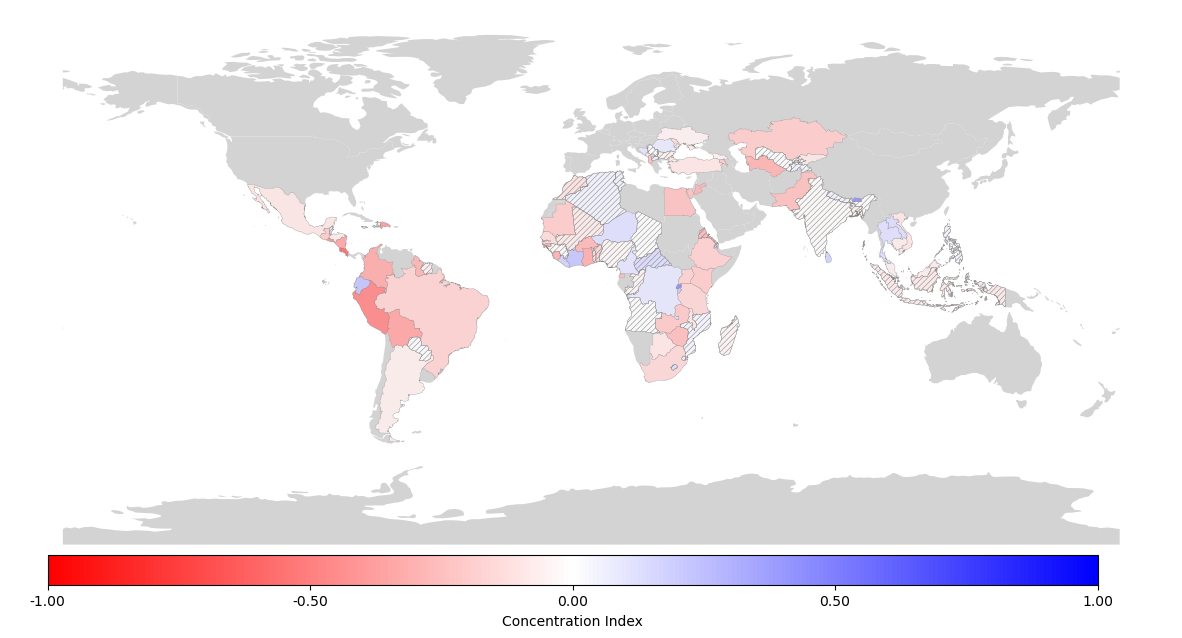

In [118]:
# Plot a map of the metrics
# Map parameters
figsize = (15, 10)
colormap = plt.cm.bwr.reversed()
colormap_min = -1
colormap_max = 1
metric = "CI_avg"
label = "Concentration Index"
hatch_pattern = "//////"  # hashes for disagreement
mpl.rcParams['hatch.linewidth'] = 0.4
mpl.rcParams['hatch.color'] = 'black'

# Create a copy of original dataframe for mapping
map_df = gdf_plot.copy()
# Simplify the admin boundaries (useful for plotting)
map_df['geometry'] = map_df['geometry'].simplify(tolerance=0.1)

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Create a basemap of the world
world_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
try:
    world = gpd.read_file(world_url)
    world.plot(ax=ax, color='lightgray')
except Exception as e:
    print(f"Couldn't load world map from URL: {e}")
    print("Proceeding without background world map")

# Plot data for available countries
if metric in map_df.columns:
    # Create a mask for rows with non-null metric values
    valid_data = ~map_df[metric].isna()

    # Colormap normalizatoin
    norm = Normalize(vmin=colormap_min, vmax=colormap_max)

    # Plot coutnries with data using metric to control color
    map_df[valid_data].plot(column=metric,
                            ax=ax,
                            cmap=colormap,
                            norm=norm,
                            edgecolor='gray',
                            linewidth=0.2,
                            alpha=0.9)
    
    # 2) HATCH ONLY countries with NO sign agreement
    disagree = (map_df['sign_agree'] == False) & valid_data
    if disagree.any():
        map_df.loc[disagree].plot(
            ax=ax,
            facecolor="none",
            edgecolor='grey',
            linewidth=0.2,
            hatch=hatch_pattern,
            alpha=0.9,
        )

    sm = ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    
    # Create the colorbar with custom positioning
    cax = fig.add_axes([0.15, 0.2, 0.7, 0.03])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    # Create evenly spaced ticks (5 ticks including min and max)
    tick_values = np.linspace(colormap_min, colormap_max, 5)
    cbar.set_ticks(tick_values)
    # Format the tick labels to have fewer decimal places
    cbar.set_ticklabels([f"{v:.2f}" for v in tick_values])
    cbar.set_label(label)

# # Add title explicitly to the ax object, not using plt.title
# ax.set_title(title, fontsize=15, pad=20)

# Turn off the axis
ax.set_axis_off()

plt.show()

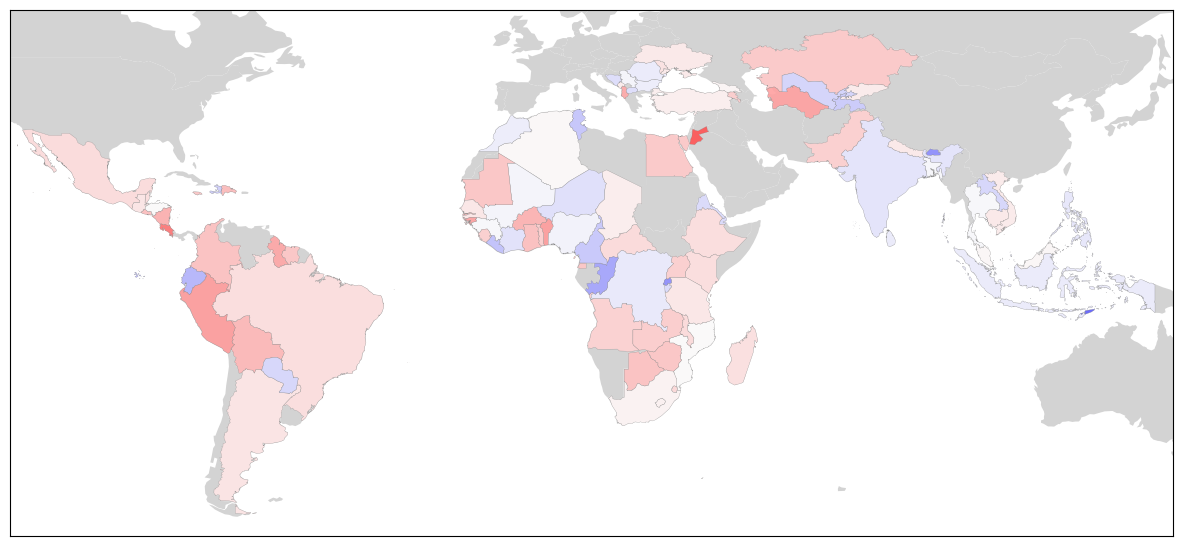

In [119]:
# Plot a map of individual model metrics
# Assing specific model to gdf_plot
gdf_plot = wri_metrics.copy()
# Map parameters
figsize = (15, 10)
colormap = plt.cm.bwr.reversed()
colormap_min = -1
colormap_max = 1
metric = "CI"
label = "Concentration Index"
proj = "EPSG:4326"
# Set map boundaries
xmin = -120
xmax = 145
ymin = -60
ymax = 60

# Create a copy of original dataframe for mapping
map_df = gdf_plot.copy()
map_df = map_df.set_crs(4326)
map_df['geometry'] = map_df['geometry'].simplify(tolerance=0.1)
map_df = map_df.to_crs(proj) # reproject

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Load world map
# Create a basemap of the world
world_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
try:
    world = gpd.read_file(world_url).to_crs(proj)
    world.plot(ax=ax, color='lightgray')
except Exception as e:
    print(f"Couldn't load world map from URL: {e}")
    print("Proceeding without background world map")

# Plot data for available countries
if metric in map_df.columns:
    # Create a mask for rows with non-null metric values
    valid_data = ~map_df[metric].isna()

    # Colormap normalizatoin
    norm = Normalize(vmin=colormap_min, vmax=colormap_max)

    # Plot coutnries with data using metric to control color
    map_df[valid_data].plot(column=metric,
                            ax=ax,
                            cmap=colormap,
                            norm=norm,
                            edgecolor='gray',
                            linewidth=0.2,
                            alpha=0.9)
    
    # # 2) HATCH ONLY countries with NO sign agreement
    # disagree = (map_df['sign_agree'] == False) & valid_data
    # if disagree.any():
    #     map_df.loc[disagree].plot(
    #         ax=ax,
    #         facecolor="none",
    #         edgecolor='grey',
    #         linewidth=0.2,
    #         hatch=hatch_pattern,
    #         alpha=0.9,
    #     )

    # sm = ScalarMappable(cmap=colormap, norm=norm)
    # sm.set_array([])
    
    # # Create the colorbar with custom positioning
    # cax = fig.add_axes([0.15, 0.2, 0.7, 0.03])  # [left, bottom, width, height]
    # cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    # # Create evenly spaced ticks (5 ticks including min and max)
    # tick_values = np.linspace(colormap_min, colormap_max, 5)
    # cbar.set_ticks(tick_values)
    # # Format the tick labels to have fewer decimal places
    # cbar.set_ticklabels([f"{v:.2f}" for v in tick_values])
    # cbar.set_label(label)

# Set extent
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# # Add border around the map extent
# rect = mpatches.Rectangle(
#     (xmin, ymin),                     # lower left corner
#     xmax - xmin, ymax - ymin,         # width, height
#     fill=False, color='black', linewidth=1,
#     transform=ax.transData, zorder=10
# )
# ax.add_patch(rect)

# # Add title explicitly to the ax object, not using plt.title
# ax.set_title(title, fontsize=15, pad=20)

# # Turn off the axis ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# ax.set_axis_off()

plt.show()

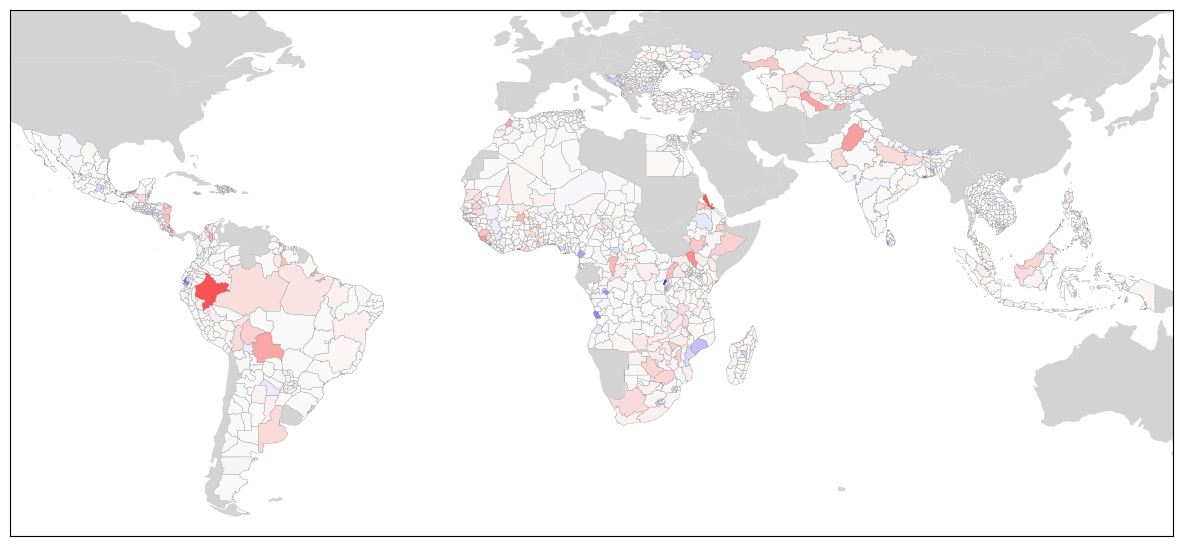

In [124]:
# Plot a map of subnatinal individual model metrics
# Assing specific model to gdf_plot
gdf_plot = giri_subnational_metrics.copy()
# Map parameters
figsize = (15, 10)
colormap = plt.cm.bwr.reversed()
colormap_min = -0.5
colormap_max = 0.5
metric = "Nat_Contrib"
label = "Concentration Index"
proj = "EPSG:4326"
# Set map boundaries
xmin = -120
xmax = 145
ymin = -60
ymax = 60

# Create a copy of original dataframe for mapping
map_df = gdf_plot.copy()
map_df = map_df.set_crs(4326)
map_df['geometry'] = map_df['geometry'].simplify(tolerance=0.1)
map_df = map_df.to_crs(proj) # reproject

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Load world map
# Create a basemap of the world
world_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
try:
    world = gpd.read_file(world_url).to_crs(proj)
    world.plot(ax=ax, color='lightgray')
except Exception as e:
    print(f"Couldn't load world map from URL: {e}")
    print("Proceeding without background world map")

# Plot data for available countries
if metric in map_df.columns:
    # Create a mask for rows with non-null metric values
    valid_data = ~map_df[metric].isna()

    # Colormap normalizatoin
    norm = Normalize(vmin=colormap_min, vmax=colormap_max)

    # Plot coutnries with data using metric to control color
    map_df[valid_data].plot(column=metric,
                            ax=ax,
                            cmap=colormap,
                            norm=norm,
                            edgecolor='gray',
                            linewidth=0.2,
                            alpha=0.9)
    
    # # 2) HATCH ONLY countries with NO sign agreement
    # disagree = (map_df['sign_agree'] == False) & valid_data
    # if disagree.any():
    #     map_df.loc[disagree].plot(
    #         ax=ax,
    #         facecolor="none",
    #         edgecolor='grey',
    #         linewidth=0.2,
    #         hatch=hatch_pattern,
    #         alpha=0.9,
    #     )

    # sm = ScalarMappable(cmap=colormap, norm=norm)
    # sm.set_array([])
    
    # # Create the colorbar with custom positioning
    # cax = fig.add_axes([0.15, 0.2, 0.7, 0.03])  # [left, bottom, width, height]
    # cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    # # Create evenly spaced ticks (5 ticks including min and max)
    # tick_values = np.linspace(colormap_min, colormap_max, 5)
    # cbar.set_ticks(tick_values)
    # # Format the tick labels to have fewer decimal places
    # cbar.set_ticklabels([f"{v:.2f}" for v in tick_values])
    # cbar.set_label(label)

# Set extent
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# # Add title explicitly to the ax object, not using plt.title
# ax.set_title(title, fontsize=15, pad=20)

# # Turn off the axis ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# ax.set_axis_off()

plt.show()

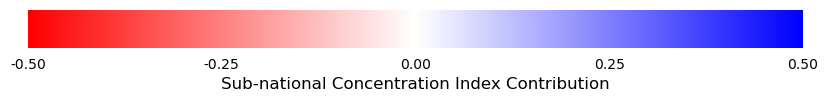

In [121]:
# Plot seperate colorbar
# Same color parameters you used in your maps
colormap = plt.cm.bwr.reversed()
colormap_min = -0.5
colormap_max = 0.5
label = "Sub-national Concentration Index Contribution"

# Create a horizontal colorbar only
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

# Normalization and ScalarMappable
norm = mpl.colors.Normalize(vmin=colormap_min, vmax=colormap_max)
cb1 = mpl.colorbar.ColorbarBase(
    ax, cmap=colormap,
    norm=norm,
    orientation='horizontal'
)

# Customize ticks and labels
tick_values = np.linspace(colormap_min, colormap_max, 5)
cb1.set_ticks(tick_values)
cb1.set_ticklabels([f"{v:.2f}" for v in tick_values])
cb1.set_label(label, fontsize=12)

# Remove axes frame around the colorbar
ax.tick_params(axis="x", bottom=False, top=False, labelsize=10)
ax.set_frame_on(False)

# Save high-quality image (transparent background is ideal for PowerPoint)
plt.savefig("colorbar_CI.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

In [53]:
# Prepare the data
bar_plot = combined.copy()
bar_plot = bar_plot.drop(columns=['Population', 'Population Coverage (%)'])
# Add a combined model column
avg_df = (bar_plot.groupby('shapeName', as_index=False)
         .agg({
             "CI": "mean",
             "Total Flood Risk": "mean", 
             "geometry": "first",
             "ISO3": "first"
         }))
avg_df["model"] = "average"
bar_plot = pd.concat([bar_plot, avg_df], ignore_index=True)

bar_plot.tail()

,ISO3,shapeName,CI,Total Flood Risk,model,geometry
371,UKR,Ukraine,-0.058138,8.234725e+04,average,"MULTIPOLYGON (((23.61783 51.50789, 23.61886 51..."
372,UZB,Uzbekistan,0.006146,8.259204e+04,average,"MULTIPOLYGON (((58.62416 42.76633, 58.62421 42..."
373,VNM,Vietnam,-0.097332,1.962094e+06,average,"MULTIPOLYGON (((104.44174 10.42368, 104.44268 ..."
374,ZMB,Zambia,-0.213072,2.181456e+04,average,"POLYGON ((23.43421 -17.63786, 23.43363 -17.636..."
375,ZWE,Zimbabwe,-0.256347,1.385053e+04,average,"POLYGON ((29.37531 -22.19547, 29.37392 -22.195..."


In [54]:
len(bar_plot[bar_plot['model']=='average'])

94

C:\Users\Mark.DESKTOP-UFHIN6T\AppData\Local\Temp\ipykernel_26976\2259084633.py:12: FutureWarning: The provided callable <function nanmin at 0x000001FFF3C67880> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  .pivot_table(index=country_col, values=value_col, aggfunc=[np.nanmin, np.nanmax]))
C:\Users\Mark.DESKTOP-UFHIN6T\AppData\Local\Temp\ipykernel_26976\2259084633.py:12: FutureWarning: The provided callable <function nanmax at 0x000001FFF3C679C0> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  .pivot_table(index=country_col, values=value_col, aggfunc=[np.nanmin, np.nanmax]))


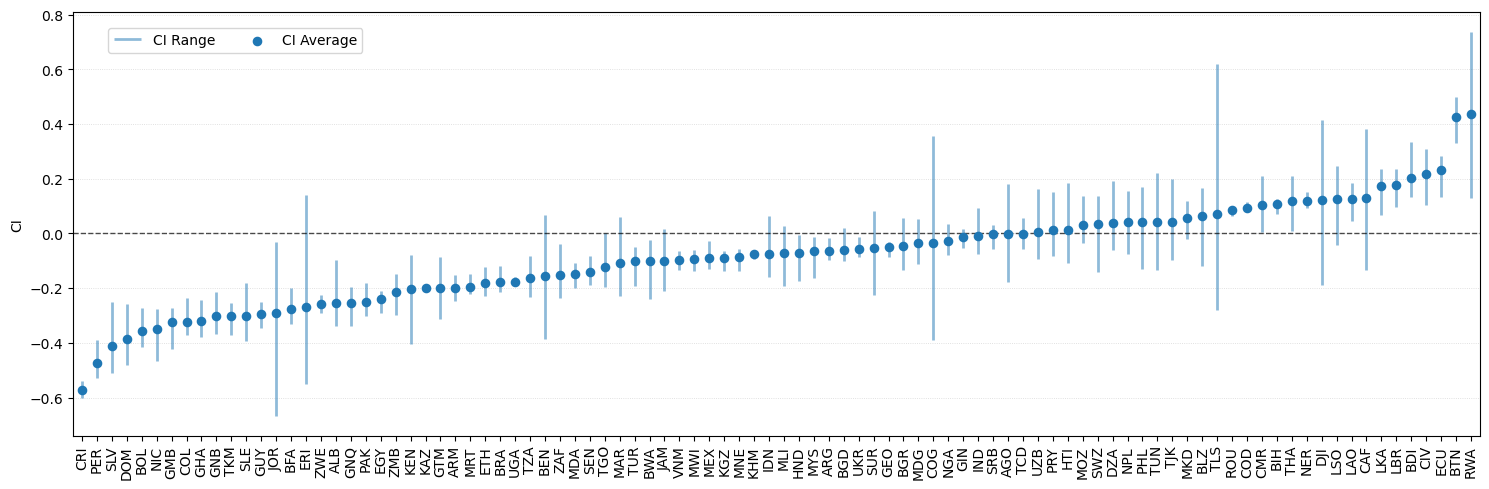

In [18]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def plot_ci_dumbbell(df, country_col="ISO3", model_col="model", value_col="CI",
                     models=("JRC","GIRI","WRI"), top_n=50):
    # Order by average
    avg = (df[df[model_col]=="average"][[country_col, value_col]]
           .rename(columns={value_col:"avg"}))
    order = avg.sort_values("avg")[country_col].tolist()

    # Min/max across individual models
    spread = (df[df[model_col].isin(models)]
              .pivot_table(index=country_col, values=value_col, aggfunc=[np.nanmin, np.nanmax]))
    spread.columns = ["minCI","maxCI"]; spread = spread.reset_index()

    d = (avg.merge(spread, on=country_col, how="left")
            .dropna(subset=["minCI","maxCI"]))
    d[country_col] = pd.Categorical(d[country_col], categories=order, ordered=True)
    d = d.sort_values(country_col)

    # # Optional: focus on most extreme (top/bottom) countries to avoid wall of labels
    # if top_n and len(d) > top_n:
    #     k = top_n//2
    #     keep = pd.concat([d.head(k), d.tail(top_n-k)])
    #     d = keep

    x = np.arange(len(d))
    fig, ax = plt.subplots(figsize=(15, 5))
    # range lines
    ax.vlines(x, d["minCI"], d["maxCI"], linewidth=2, alpha=0.5, label = "CI Range")
    # average point
    ax.scatter(x, d["avg"], s=35, label="CI Average", zorder=3)
    # end caps
    # ax.scatter(x, d["minCI"], s=20, marker="s", label="Min (JRC/GIRI/WRI)")
    # ax.scatter(x, d["maxCI"], s=20, marker="^")

    ax.axhline(0, ls="--", lw=1, alpha=0.7, color='k')
    ax.set_xticks(x); ax.set_xticklabels(d[country_col], rotation=90, ha="center", va="top")
    ax.set_xlim(-0.6, x.max()+0.6)
    ax.set_ylabel("CI"); 
    ax.legend(ncol=3, frameon=True, loc="upper left", bbox_to_anchor=(0.02,0.98))
    ax.grid(axis="y", ls=":", lw=0.6, alpha=0.5)
    plt.tight_layout(); plt.show()

plot_ci_dumbbell(bar_plot)